# Visualization of molar volume during a liquid-gas phase transition


**Code:** #112-000

**File:** `apps/van_der_waals/phase_transition_volume.ipynb`

-----------

The aim os this notebook is to visualize the change in molar volume during a liquid-gas phase transition.

## Interface

The main interface (`main_block_112_000`) is divided in two HBox: `top_block` and `middle_block`.

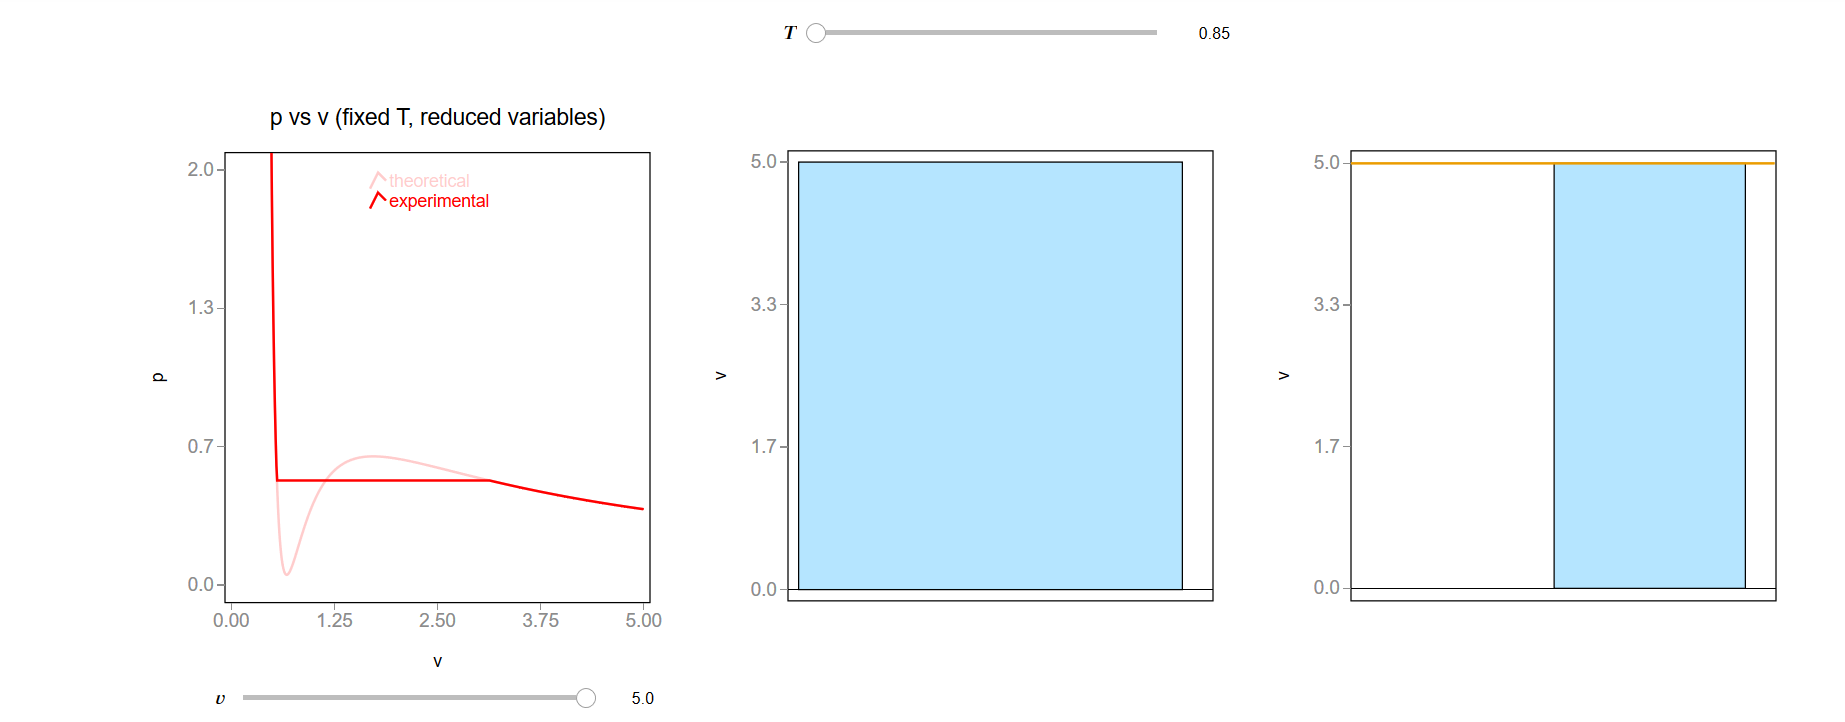

In [19]:
from IPython.display import Image
Image(filename='../../static/images/112-000_1.png')

`top_block` consists in a single slider `T_slider` which calls to the function `change_tenperature` to change the isotherm which is shown in the figure `fig_112_001`.

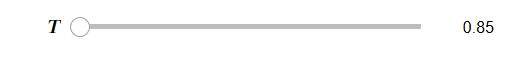

In [20]:
Image(filename='../../static/images/112-000_2.png')

`middle_block` consists in three bqplot figures (from left to right: `fig_112_001`, `fig_112_002` and `fig_112_003`) and a slider (`v_slider`) which calls the function `update_tracer` to update the position of the tracing point in figure `fig_112_001` and the size and colors of the bars of the figures `fig_112_002` and `fig_112_003`.

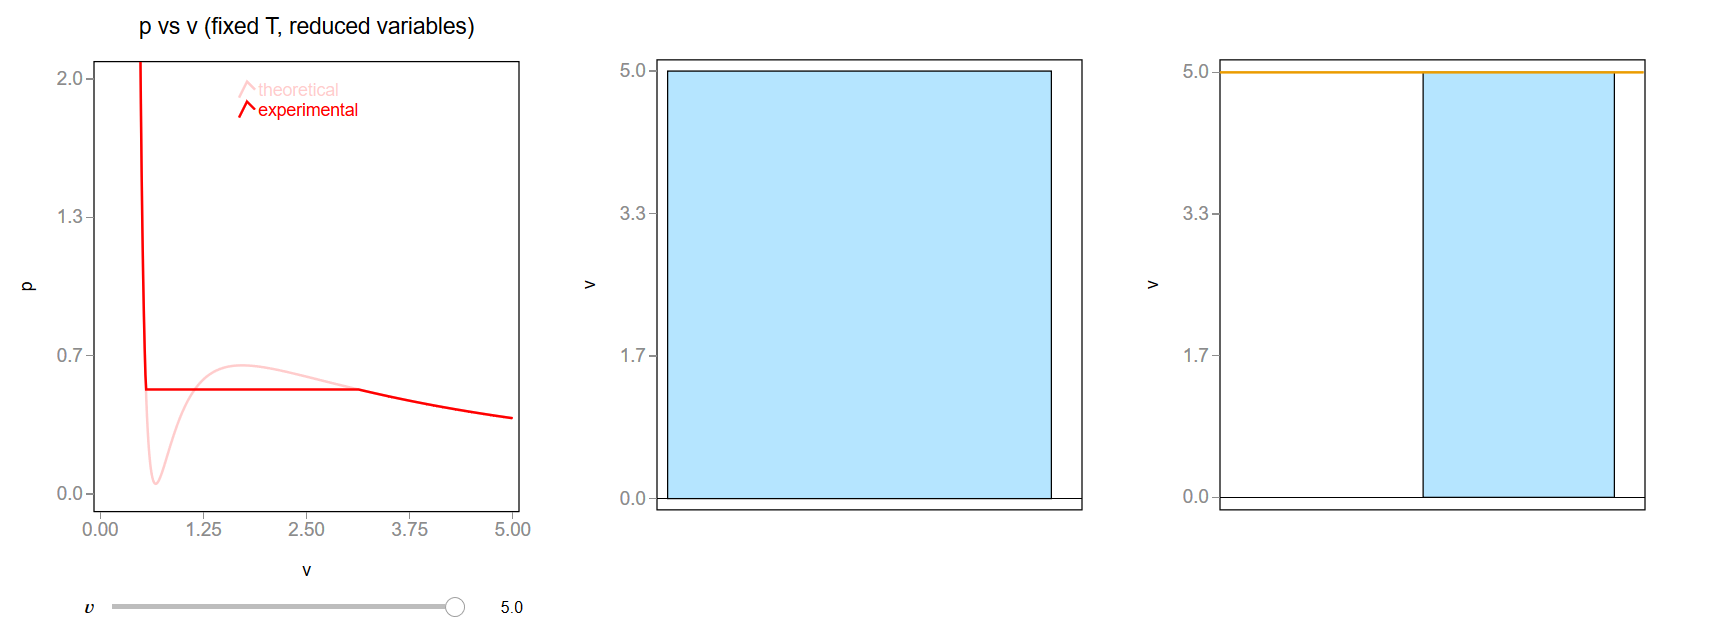

In [21]:
Image(filename='../../static/images/112-000_3.png')

## CSS

A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [1]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages

In [2]:
from bqplot import *
import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

import numpy as np

## Physical functions

In [3]:
def get_relative_isotherms(v_range, T_range):
    """This function calculates the theoretical p(v, T) plane 
        (in reduced coordinates) according to Van der Waals
        equation of state from a given range of volumes
        and tenperatures.

    Args:
        v_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n
        T_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n

        
    Returns:
        isotherms: A list consisted consisted of numpy arrays containing the
        pressures of each isotherm.
    """

    isotherms = []

    for T in T_range:
        p_R = []
        for v in v_range:
            val = (8.0/3.0*T/(v - 1.0/3.0) - 3.0/v**2)
            p_R = np.append(p_R, val)

        isotherms.append(p_R)

    return isotherms

In [4]:
def experimental_isotherms(v_range, T_range):
    """This function calculates the experimental p(v, T) plane 
        (in reduced coordinates) according to Van der Waals
        equation of state from a given range of volumes
        and tenperatures.

    Args:
        v_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n
        T_range: An array containing the values of v
        (in reduced coordinates)for which the isotherms must be 
        calculated.\n

        
    Returns:
        expe_data: A list consisted of numpy arrays containing the
        pressures of each theoretical isotherm.\n
        theo_data: A list consisted of numpy arrays containing the
        pressures of each theoretical isotherm.\n
        v_limits: A list consisted of arrays of the volume limits of
        the phase-transition of each subcritical isotherm.\n
        p_limits: A list consisted of arrays of the pressure limits of
        the phase-transition of each subcritical isotherm.\n
    """
    
    theo_data = get_relative_isotherms(v_range, T_range)
    expe_data = []
    
    v_limits = []
    p_limits = []

    for i in range(len(theo_data)):
        
        T = T_range[i]

        if T < 1.0:
            
            #try:
            p_theo = theo_data[i]
            p_expe = []
            #p_max = scipy.signal.argrelmax(p)
            #print(p_max)
            #p_min = scipy.signal.argrelmin(p)
            #print(p_min)
            p_range = np.linspace(0.001, 1.0, num=5000)
            p, v_isopressure_limits = find_real_fixed_T(p_range, T)

            for j in range(len(v_range)):
                if v_range[j] > v_isopressure_limits[0] and v_range[j] < v_isopressure_limits[-1]:
                    p_expe.append(p)

                else:
                    p_expe.append(p_theo[j])

            expe_data.append(p_expe)
            v_limits.append([v_isopressure_limits[0], v_isopressure_limits[1]])
            p_limits.append([p, p])

            #except: # Exception as e:

                #expe_data[t] = []
                #v_limits[t] = []
                #p_limits[t] = []
        else:
            expe_data.append(theo_data[i])
            
            if T == 1.0:
                v_limits.append([1.0])
                p_limits.append([1.0])
               
    return expe_data, theo_data, v_limits, p_limits

In [5]:
def get_roots(p, T):
    """This function finds the intersection between an isobaric curve
       and Van der Waals equation of state for a given T.\n
       Values of v with no physical meaning are dismissed
       (v < 0 or complex).

    Args:
        p: Pressure of the isobaric curve.\n
        T: Tenperature of the isotherm.\n

        
    Returns:
        roots_in_range: A sorted list of the volumes in which the
        isobaric curve intersects the isotherm.\n
    """
    
    roots = np.roots([1.0, - 1.0/3.0*(1.0 + 8.0*T/p), 3.0/p, -1.0/p])
    roots_in_range = []
    
    for root in roots:
        
        # A third degree polynomial has 3 complex roots,
        # but we are only interested in the ones which are
        # purely real.
        
        if np.isreal(root): 
            root = np.real(root)
            if root > 0:
                roots_in_range.append(root)

    roots_in_range.sort()
    
    return roots_in_range

In [6]:
def p_undefined_integral(p_0, v_0, T):
    """This function calculates the value of the 
       indefinite integral of an isotherm of tenperature
       T at a point (p0, v0).\n

    Args:
        p0: Pressure at which the integral is evaluated.\n
        v0: Volume at which the integral is evaluated.\n
        T: Tenperature of the isotherm.\n

        
    Returns:
       The value of the indefinite integral of an
       isotherm of tenperature T at a point (p0, v0).\n
    """
    
    return 8.0/3.0 * T *np.log(v_0 - 1.0/3.0) + 3.0/v_0 - p_0*v_0

In [7]:
def defined_integral(p_0, v_range, T):
    """This function calculates the value of the 
       indefinite integral of an isotherm of tenperature
       T at a pressure p0 and in a range v_range.\n

    Args:
        p0: Pressure at which the integral is evaluated.\n
        v_range: Volume range at which the integral is evaluated.\n
        T: Tenperature of the isotherm.\n

        
    Returns:
       The value of the definite integral of an
       isotherm of tenperature T at a pressure p0 and in
       a range v_range.\n
    """
    
    v_0, v_1 = v_range[0], v_range[1]
    return p_undefined_integral(p_0, v_1, T) - p_undefined_integral(p_0, v_0, T)

In [8]:
def find_real_fixed_T(p_range, T):
    """This function uses Maxwell's construction to find the
       pressures in which phase transition happens.\n

    Args:
        p_range: Pressure range in which the real isotherm is
        searched.\n
        T: Tenperature of the isotherm.\n

        
    Returns:
        None if no phase transition is possible for that isotherm 
        in that pressure range.\n
        p: Pressure in which the phase transition happens.\n
        v_range: Volume limits of the phase transition happens.
    """
    
    eps = 1e-3 #1.0/p_range.size
    
    for p in p_range:
        
        roots = get_roots(p, T)
        if len(roots) == 3:
            v_range = (roots[0], roots[2])
            area = defined_integral(p, v_range, T)
            if abs(area) < eps:
                return p, v_range

    return None

In [9]:
def get_volumes_propotions(v_limits, v):
    """This function calculates the propotion of gas/liquid 
       during a phase transistion at a volume v.\n

    Args:
        v_limits: Volume limits in which the phase transition
        happens.\n
        v: value of the volume.\n

        
    Returns:
        x_g: propotion of the gas phase.\n
        x_l: propotion of the liquid phase.
    """
    
    v_l = v_limits[0]
    v_g = v_limits[1]
    
    x_l = (v_g - v)/(v_g - v_l)
    x_g = (v - v_l)/(v_g - v_l)
    
    return x_g, x_l

## Functions related with the interaction

In [10]:
def update_tracer(change):
    """This function update the position of the tracer and the
       values and colors of the bars.\n
    """
    
    
    tracer_112_001.visible = True
      
    i = change.get('owner').index
    v = v_values[i]
    p = expe_data[T_slider.index][i]

    tracer_112_001.x, tracer_112_001.y = [v], [p]
    
    lines_112_003.y = [v, v]
    
    if T_slider.value < 1.0:
    
        v_g = v_limits[T_slider.index][1]
        v_l = v_limits[T_slider.index][0]

        if v > v_g:

            bar_112_002.colors = ['#b5e5ff', 'blue']
            bar_112_002.y = [[v],[0.0]]

            bar_112_003.colors = ['blue', '#b5e5ff']
            bar_112_003.y = [[0.0], [v]]

        elif v > v_l and  v < v_g:
            x_g, x_l = get_volumes_propotions((v_l, v_g), v)

            bar_112_002.colors = ['blue', '#b5e5ff']
            bar_112_002.y = [[v_l*x_l], [v_g*x_g]]

            bar_112_003.colors = ['blue', '#b5e5ff']
            bar_112_003.y = [[v_l*x_l], [v_g*x_g]]

        elif v < v_l:

            bar_112_002.colors = ['#b5e5ff', 'blue']
            bar_112_002.y = [[0.0], [v]]
            
            bar_112_003.colors = ['blue', '#b5e5ff']
            bar_112_003.y = [[v], [0.0]]
            
    else:
        
        bar_112_002.y = [[v],[0.0]]
        bar_112_002.colors = [gradient[i]]
        
        bar_112_003.y = [[v]]
        bar_112_003.colors = [gradient[i]]

In [11]:
def change_tenperature(change):
    """This function changes the visible isotherm in the figure.\n
    """
    
    lines_112_001.y = [theo_data[T_slider.index], expe_data[T_slider.index]]
    v_slider.value = v_slider.options[-1]

    i = v_slider.index
    
    v = v_values[i]
    p = expe_data[T_slider.index][i]

    tracer_112_001.x, tracer_112_001.y = [v], [p]

## Functions related with the visualization

In [12]:
def hex_to_rgb(number_hex):
    """This function converts a color expressed in
       hexadecimal to rgb.\n

    Args:
        number_hex: A string expressing a color in hexadecimal format.\n
        
    Returns:
        A tuple containing the three integers of the rgb color.
    """
    
    if number_hex.startswith('#'):
        number_hex = number_hex[1:]
    
    return (int(number_hex[0:2], 16), int(number_hex[2:4], 16), int(number_hex[4:], 16))

In [13]:
def rgb_to_hex(number_rgb):
    """This function converts a color expressed in
       rgb to hexadecimal.\n

    Args:
        number_rgb: A tuple containing the three integers of the rgb color.\n
        
    Returns:
        A string expressing a color in hexadecimal format.
    """
    
    return '#' + format(number_rgb[0], '02x') + format(number_rgb[1], '02x') + format(number_rgb[2], '02x')

In [14]:
def generate_gradient(initial, final, length):
    """This function generates a list of colors forming a gradient
       from initial color to final color.\n

    Args:
        initial: Initial color of the gradient in hexadecimal
        format.\n
        final: Final color of the gradient in hexadecimal
        format.\n
        lenght: An integer expressing the number of colors to
        calculate.\n
        
    Returns:
        colors: A list consisted of the strings  of the colors
        colors of the gradient in hexadecimal format.
    """
    
    i_r, i_g, i_b = hex_to_rgb(initial)
    f_r, f_g, f_b = hex_to_rgb(final)
    
    r_step = (f_r - i_r)/length
    g_step = (f_g - i_g)/length
    b_step = (f_b - i_b)/length
    
    r, g, b = i_r, i_g, i_b
    colors = []
    
    for i in range(length):

        h = rgb_to_hex((int(round(r)),int(round(g)),int(round(b))))
        
        colors.append(h)
        
        r = r + r_step
        g = g + g_step
        b = b + b_step

    return colors

## Main interface

In [15]:
"""This module visualizes the change in molar volumen of both phases
during a liquid-gas phase transition.

"""

v_values = np.linspace(0.4, 5.0, 500)
T_values = np.round(np.linspace(0.85, 1.2, 10), 2)

colors = ['#221ba1','#b5e5ff'] #light blue, dark_blue
gradient = generate_gradient(colors[0], colors[1], 500)

expe_data, theo_data, v_limits, p_limits = experimental_isotherms(v_values, T_values)

# TOP BLOCK

top_block = widgets.VBox(
    [],
    layout=widgets.Layout(
        align_items='center',
        width='100%')
)

T_slider = widgets.SelectionSlider(
    options= T_values,
    value=T_values[0],
    description=r'\( T \)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout = widgets.Layout(
        width = '33%',
        align_self='center',
        margin='20px 0 0 0'
    )
)

T_slider.observe(change_tenperature, 'value')

top_block.children = [T_slider]

# MIDDLE BLOCK

middle_block = widgets.HBox(
    [],
    layout=widgets.Layout(
        align_items='center',
        width='100%')
)

scale_x = bqs.LinearScale(min = 0.0, max = max(v_values))
scale_y = bqs.LinearScale(min = 0, max = 2.0)

axis_x = bqa.Axis(scale=scale_x,
                tick_format='.2f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0, max(v_values), 5),
                #num_ticks=5,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='v',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y = bqa.Axis(
                scale=scale_y,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0, 2.0, 4),
                #num_ticks=4,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='p',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_112_001 = bq.Figure(
                title='p vs v (fixed T, reduced variables)',    
                marks=[],
                axes=[axis_x, axis_y],
                animation_duration=0, #500,
                #layout = widgets.Layout(align_self='center', width='75%'),
                legend_location='top-right',
                legend_text =  {'font-size': '14px'},
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=80, bottom=60, left=80, right=30),
                toolbar = True,
                layout = widgets.Layout(
                    width='100%',
                    height='500px'
                ),
    )

lines_112_001 = bqm.Lines(
                x = v_values, 
                y = [theo_data[T_slider.index], expe_data[T_slider.index]], 
                scales = {'x': scale_x, 'y': scale_y}, 
                opacities = [0.2, 1.0],
                visible = True, #True, #t == '1.00',
                colors = ['red'],
                labels = ['theoretical', 'experimental'],
                display_legend = True
)

tracer_112_001 = bqm.Scatter(
        name = '',
        x = [0.0],
        y = [0.0],
        scales = {'x': scale_x, 'y': scale_y}, 
        opacity = [1.0, 0.0],
        visible = False,
        colors = ['#2807a3'],
    )

fig_112_001.marks = [lines_112_001, tracer_112_001]

v_values_rounded = np.round(v_values, 3)

v_slider = widgets.SelectionSlider(
    options=v_values_rounded,
    value=v_values_rounded[-1],
    description=r'\( v \)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout = widgets.Layout(
        width = '100%',
        margin='0 50px 0 50px'
    )
)

v_slider.observe(update_tracer, 'value')

ordinal_scale = bqs.OrdinalScale()

bar_112_002 = bqm.Bars(x=[1.0],
                       y=[max(v_values)],
                       scales={'x': ordinal_scale, 'y': scale_x},
                       colors=['#b5e5ff', 'blue'],
                      )

original_112_002 = bqm.Bars(
                       x=[1.0],
                       y=[max(v_values)],
                       scales={'x': ordinal_scale, 'y': scale_x},
                       colors=['#d9d9d9'],
                       opacities = [0.2])

axis_x_002 = bqa.Axis(
                scale=ordinal_scale,
                tick_format='.2f',#'0.2f',
                tick_style={'font-size': '15px'},
                #tick_values = np.linspace(0, max(v_values), 5),
                num_ticks=0,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y_002 = bqa.Axis(
                scale=scale_x,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0, max(v_values), 4),
                #num_ticks=4,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='v',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_112_002 = bq.Figure(title='',
                marks=[],
                axes=[axis_x_002, axis_y_002],
                animation_duration=0, #500,
                #layout = widgets.Layout(align_self='center', width='75%'),
                legend_location='top-right',
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=65, bottom=75, left=80, right=30),
                toolbar = True,
                layout = widgets.Layout(
                    width='100%',
                    height='500px'
                )
    )

fig_112_002.marks = [original_112_002, bar_112_002, ]

bar_112_003 = bqm.Bars(x=[[1.0],[1.0]],
                       y=[[0.0], [max(v_values)]],
                       scales={'x': ordinal_scale, 'y': scale_x},
                       colors=['blue', '#b5e5ff'],
                       type='grouped'
                      )

lines_112_003 = bqm.Lines(
                        x = [-5.0, 5.0], 
                        y = [max(v_values), max(v_values)], 
                        scales = {'x': scale_x, 'y': scale_x}, 
                        #opacities = [0.4],
                        visible = True, #True, #t == '1.00',
                        colors = ['#eb9c00'],
                        )

axis_x_003 = bqa.Axis(
                scale=ordinal_scale,
                tick_format='.2f',#'0.2f',
                tick_style={'font-size': '15px'},
                #tick_values = np.linspace(0, max(v_values), 5),
                num_ticks=0,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                label='',
                label_location='middle',
                label_style={'stroke': 'black', 'default-size': 35},
                label_offset='50px')

axis_y_003 = bqa.Axis(
                scale=scale_x,
                tick_format='.1f',#'0.2f',
                tick_style={'font-size': '15px'},
                tick_values = np.linspace(0, max(v_values), 4),
                #num_ticks=4,
                grid_lines = 'none',
                grid_color = '#8e8e8e', 
                orientation='vertical',
                label='v',
                label_location='middle',
                label_style={'stroke': 'red', 'default_size': 35},
                label_offset='50px')

fig_112_003 = bq.Figure(title='',
                marks=[],
                axes=[axis_x_003, axis_y_003],
                animation_duration=0, #500,
                #layout = widgets.Layout(align_self='center', width='75%'),
                legend_location='top-right',
                background_style= {'fill': 'white',  'stroke': 'black'},
                fig_margin=dict(top=65, bottom=75, left=80, right=30),
                toolbar = True,
                layout = widgets.Layout(
                    width='100%',
                    height='500px'
                )
    )

fig_112_003.marks = [bar_112_003, lines_112_003]

middle_block.children = [
    widgets.VBox(
        [fig_112_001, v_slider],
        layout = widgets.Layout(align_items='center', width='33%')
    ),
    widgets.VBox(
        [fig_112_002, ],
        layout = widgets.Layout(align_items='center', width='33%')
    ),
    widgets.VBox(
        [fig_112_003],
        layout = widgets.Layout(align_items='center', width='33%')
    ),
]

# MAIN BLOCK

main_block_112_000 = widgets.VBox(
    [],
    layout=widgets.Layout(
        align_items='center',
        width='100%')
)

main_block_112_000.children = [top_block,
                               middle_block]

main_block_112_000